# **Ch05.회귀 실습 #2**

**Ch05-09. 회귀 실습 - 자전거 대여 수요 예측**

* 주제 : 자전거 대여 수요 예측 - 선형 회귀와 트리 기반 회귀 비교
* 데이터 셋 : https://www.kaggle.com/c/bike-sharing-demand/data
* 특징 : 해당 데이터 셋에는 2011년 1월부터 2012년 12월까지 날짜/시간, 기온, 습도, 풍속 등의 정보를 기반으로 1시간 간격 동안의 자전거 대여 횟수가 기재되어있음. target값은 맨 마지막 칼럼인 count('대여 횟수')

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bike-sharing-demand/test.csv
/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv


## data cleansing & preprocessing

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df=pd.read_csv('/kaggle/input/bike-sharing-demand/train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [ ]:
# datetime cloumn만 object type : 년-월-일 시:분:초 문자 형식
# pandas의 datetime 타입으로 변경해야함 apply(pd.to_datetime) 메서드 이용
# 년, 월, 일, 시간 칼럼으로 추출
# 이름 동일한거 혼동 주의

# 1. 문자열을 datetime 타입으로 변경
bike_df['datetime']=bike_df.datetime.apply(pd.to_datetime)

# 2. datetime 타입에서 년,월,일,시간 추출
bike_df['year']=bike_df.datetime.apply(lambda x:x.year)
bike_df['month']=bike_df.datetime.apply(lambda x:x.month)
bike_df['day']=bike_df.datetime.apply(lambda x:x.day)
bike_df['hour']=bike_df.datetime.apply(lambda x:x.hour)
bike_df.head(3)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [ ]:
# datetime칼럼 삭제
# count = casual(미등록 사용자의 대여횟수)+registered(사전등록 사용자의 대여횟수)
# casual과 registered도 따로 필요하지 않으므로 삭제

drop_columns=['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1,inplace=True)

## 예측 성능 평가 함수
캐글에서 요구한 성능 평가 방법 : RMSLE(Root Mean Square Log Error)

but 사이킷런은 RMSLE를 제공하지 않아서 직접 함수 작성

+MAE, RMSE까지 한꺼번에 평가하는 함수 추가작성

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_squared_error()를 이용해 RMSE 계산
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

# MAE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    # MAE는 사이킷런의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3f}, MAE: {2:.3f}'.format(rmsle_val, rmse_val, mae_val))


**주의**

그냥 mean_squared_log_error사용은 오버플로나 언더플로 오류 발생이 쉽기 때문에 위와같이 log1p()사용 권장. 이 값은 다시 넘파이의 expm1()함수로 쉽게 원래 스케일로 복원 가능함

## 로그 변환, 피처 인코딩과 모델 학습/예측/평가

회귀 모델 적용 전 처리할 사항
1. 결과 값이 정규 분포로 되어있는지 확인
2. 카테고리형 회귀 모델의 경우 원ㅡ핫 인코딩으로 피처 인코딩

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1,inplace=False) # inplace=False 주의

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


In [ ]:
# 실제 값과 예측값이 어느정도 차이가 나는지 dataframe의 칼럼으로 만들어서 확인
# 오류값이 가장 큰 순으로 5개만 확인할 것임
def get_top_error_data(y_test, pred, n_tops=5):
    result_df = pd.DataFrame(y_test.values, columns=['real_count']) # dataframe만들고 실제값 칼럼 추가
    result_df['predicted_count']=np.round(pred) # 예측값 칼럼 추가
    result_df['diff']=np.abs(result_df['real_count']-result_df['predicted_count']) # 크기 차이만 본다
    
    print(result_df.sort_values('diff', ascending=False)[:n_tops]) # 5개만 내림차순으로 확인

get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


이렇게 큰 예측 오류가 발생할 경우 가장 먼저 Target값의 분포가 왜곡된 형태인지 확인!!

> Target 값의 분포는 정규 분포 형태가 가장좋음

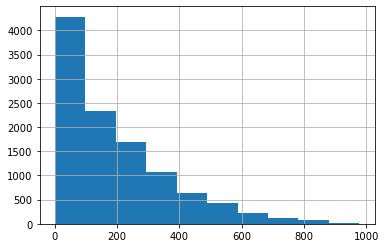

In [ ]:
y_target.hist()

* count값이 0~200 사이에 왜곡됨
* 왜곡된 값 -> 정규분포로 바꾸는 방법은 "로그 변환"
* log1p()이용 후 학습 -> expm1()로 원상 복구

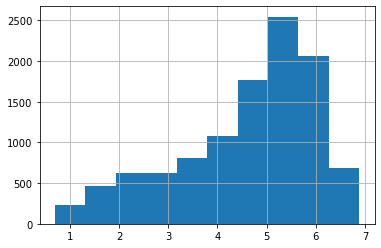

In [ ]:
y_log_transform=np.log1p(y_target)
y_log_transform.hist()

In [ ]:
# 타겟 칼럼인 count값을 log1p로 로그변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영해 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target값이 로그 변환 됐으므로 다시 expm1을 이용해 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

# 예측값도 마찬가지
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


* RMSLE는 감소됨
* RMSE는 증가됨

이유는?

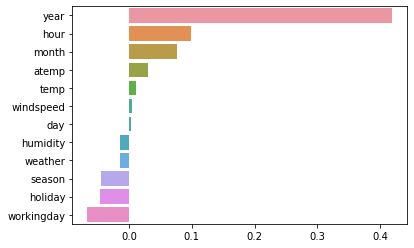

In [ ]:
# 각 피처의 회귀 계수 값을 시각화
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

* year의 회귀 계수 값이 독보적으로 큼
* year 피처는 연도이므로 카테고리형이어야하지만 숫자형값으로 되어있음
* 사이킷런은 카테고리만을 위한 데이터 타입이 없어서 모두 숫자로 변환해야함
* 따라서 이러한 피처는 원ㅡ핫 인코딩을 적용해서 변환해야함
* year뿐만아니라 month, day, hour, holiday, workingday, season, weather도!

In [ ]:
# one-hot encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month', 'day', 'hour', 'holiday', 'workingday', 'season', 'weather'])

In [ ]:
# LinearRegression, Ridge, Lasso 모두 학습해 예측 성능 확인
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)

# 모델과 학습/데스트 데이터셋 입력하면 성능 평가 수치 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred=model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
####################################################

# 모델 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg= Lasso(alpha=0.01)

for model in [lr_reg,ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True) #ohe한 다음에 expm1시켜줘야하므로

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


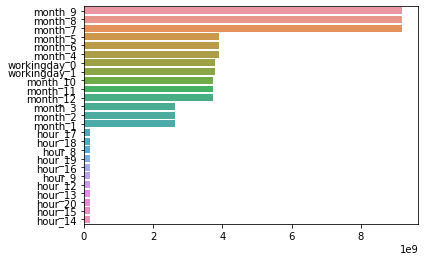

In [ ]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:25] # one-hot encoding으로 피처수 늘었으므로 확인 갯수도 25개로 늘림
sns.barplot(x=coef_sort.values, y=coef_sort.index)

## 회귀트리를 이용해서 예측 수행
* Target값의 로그 변환된 값 그대로 이용
* 원-핫 인코딩 된 피처 데이터 셋 그대로 이용
* 랜덤 포레스트, GBM, XGBoost, LightGBM을 순차적 성능 평가

📢주의

XGBoost의 경우 DataFrame이 학습/테스트 데이터로 입력될 경우 버전에 따라 오류 발생가능성이 있으므로 DataFrame의 values속성을 이용해 ndarray로 변환할것임.

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [lr_reg,gbm_reg,xgb_reg,lgbm_reg]:
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True) #ohe한 다음에 expm1시켜줘야하므로

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382


KeyboardInterrupt: 